### 参考記事
Text Analysis & Feature Engineering with NLP  
https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d  

### データセット
Real or Not? NLP with Disaster Tweets  
https://www.kaggle.com/c/nlp-getting-started/data  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from IPython.display import display

# 使用されている言語を検出するライブラリ
import langdetect 

# NLTK(Natural Language Toolkit)という、自然言語処理のライブラリ
import nltk

# TextBlob().sentiment.polarityで感情分析
from textblob import TextBlob

# spaCy 自然言語用のライブラリ
import spacy

# WordCloud用のライブラリ
import wordcloud

# このモジュールは、データセット/モデルのダウンロード、情報の取得、およびロードのためのAPI
import gensim.downloader as gensim_api

# t-SNE は、高次元データを視覚化するためのツール
from sklearn import manifold

# 主にテキスト解析を対象としたスケーラブルな機械学習ライブラリで、Word2VecやDoc2VecをシンプルなAPIで利用することができる。
import gensim

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

import warnings
warnings.filterwarnings('ignore')

### データの読み込み

In [2]:
path = os.getcwd() + "/"

In [3]:
train = pd.read_csv(path + "train.csv")
test  = pd.read_csv(path + "test.csv")

In [5]:
print("train")
display(train.head(3))
display(train.tail(3))
display(train.shape)

print("test")
display(test.head(3))
display(test.tail(3))
display(test.shape)

train


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


,id,keyword,location,text,target
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


(7613, 5)

test


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


,id,keyword,location,text
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


(3263, 4)

In [9]:
# keyword カラムとlocation カラムのボリュームを確かめる
print("train data  keyword :{0}, location :{1}".format(train["keyword"].unique().shape[0], train["location"].unique().shape[0]))
print("test data  keyword :{0}, location :{1}".format(test["keyword"].unique().shape[0], test["location"].unique().shape[0]))

train data  keyword :222, location :3342
test data  keyword :222, location :1603


In [10]:
# location は多すぎるのでカット
train = train.drop("location", axis=1)
test = test.drop("location", axis=1)

In [11]:
# keyword の null値カウント
print(train["keyword"].isnull().sum())
print(test["keyword"].isnull().sum())

61
26


In [14]:
# 欠損値の削除
train = train.dropna(axis=0)
test = test.dropna(axis=0)

,id,keyword,text,target
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,Crying out for more! Set me ablaze,0
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...
7578,10830,wrecked,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,Three days off from work and they've pretty mu...,0
7580,10832,wrecked,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,@engineshed Great atmosphere at the British Li...,0


### keyword別の分布

<AxesSubplot:title={'center':'Test'}, ylabel='keyword'>

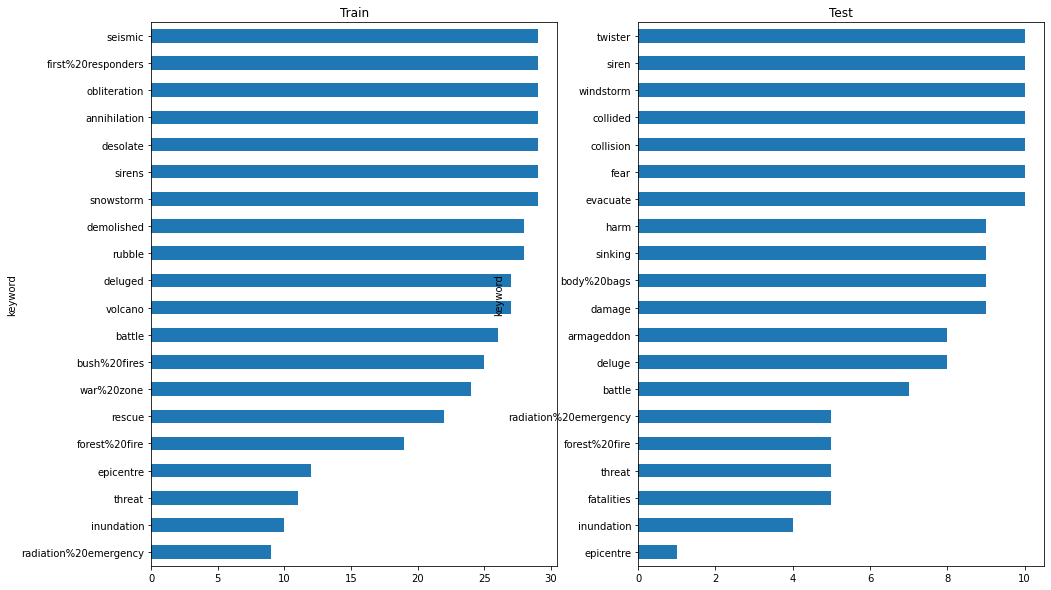

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

train["keyword"].reset_index().groupby("keyword").count().sort_values(by="index")[:20].plot(ax=axes[0], kind="barh", title='Train', legend=False)
test["keyword"].reset_index().groupby("keyword").count().sort_values(by="index")[:20].plot(ax=axes[1], kind="barh", title='Test', legend=False)

### 何語なのか判定

In [40]:
train['lang'] = train["text"].apply(lambda x: langdetect.detect(x) if 
                                 x.strip() != "" else "")

test['lang'] = train["text"].apply(lambda x: langdetect.detect(x) if 
                                 x.strip() != "" else "")

In [44]:
display(train.head())
display(test.head())

,id,keyword,text,target,lang
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,en
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,en
2,5,NaN,All residents asked to 'shelter in place' are ...,1,en
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,en
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,en


,id,keyword,text,lang
0,0,NaN,Just happened a terrible car crash,en
1,2,NaN,"Heard about #earthquake is different cities, s...",en
2,3,NaN,"there is a forest fire at spot pond, geese are...",en
3,9,NaN,Apocalypse lighting. #Spokane #wildfires,en
4,11,NaN,Typhoon Soudelor kills 28 in China and Taiwan,en


### 記号 （ ' や ! や その他諸々）の入ったテキストの確認

In [47]:
print("train")
display(train[train["text"].str.contains(r'[^\s\w]')].head(3))
display(train[train["text"].str.contains(r'[^\s\w]')].tail(3))
display(train[train["text"].str.contains(r'[^\s\w]')]["text"].count().sum())

print("test")
display(test[test["text"].str.contains(r'[^\s\w]')].head(3))
display(test[test["text"].str.contains(r'[^\s\w]')].tail(3))
display(test[test["text"].str.contains(r'[^\s\w]')]["text"].count().sum())

train


,id,keyword,text,target,lang
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,en
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,en
2,5,NaN,All residents asked to 'shelter in place' are ...,1,en


,id,keyword,text,target,lang
7610,10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,en
7611,10872,NaN,Police investigating after an e-bike collided ...,1,en
7612,10873,NaN,The Latest: More Homes Razed by Northern Calif...,1,en


7277

test


,id,keyword,text,lang
1,2,NaN,"Heard about #earthquake is different cities, s...",en
2,3,NaN,"there is a forest fire at spot pond, geese are...",en
3,9,NaN,Apocalypse lighting. #Spokane #wildfires,en


,id,keyword,text,lang
3260,10868,NaN,Green Line derailment in Chicago http://t.co/U...,en
3261,10874,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,en
3262,10875,NaN,#CityofCalgary has activated its Municipal Eme...,en


3126

### 記号を削除

In [48]:
train['text_clean'] = train["text"].apply(lambda x: re.sub(r'[^\w\s]',
                                                     '', x).lower().strip())

test['text_clean'] = test["text"].apply(lambda x: re.sub(r'[^\w\s]',
                                                     '', x).lower().strip())

display(train.head())
display(test.head())

,id,keyword,text,target,lang,text_clean
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,en,our deeds are the reason of this earthquake ma...
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,en,forest fire near la ronge sask canada
2,5,NaN,All residents asked to 'shelter in place' are ...,1,en,all residents asked to shelter in place are be...
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,en,13000 people receive wildfires evacuation orde...
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,en,just got sent this photo from ruby alaska as s...


,id,keyword,text,lang,text_clean
0,0,NaN,Just happened a terrible car crash,en,just happened a terrible car crash
1,2,NaN,"Heard about #earthquake is different cities, s...",en,heard about earthquake is different cities sta...
2,3,NaN,"there is a forest fire at spot pond, geese are...",en,there is a forest fire at spot pond geese are ...
3,9,NaN,Apocalypse lighting. #Spokane #wildfires,en,apocalypse lighting spokane wildfires
4,11,NaN,Typhoon Soudelor kills 28 in China and Taiwan,en,typhoon soudelor kills 28 in china and taiwan


### トークン化

In [49]:
# text カラムを配列に変更
txt_train = train["text_clean"].values.tolist()
txt_test  = test["text_clean"].values.tolist()

In [50]:
# 単語に分解してトークン化
txt_train = [x.split() for x in txt_train]
txt_test = [x.split() for x in txt_test]

In [51]:
# リストの最初の要素を表示
display(txt_train[0])
display(txt_test[0])

['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 'earthquake',
 'may',
 'allah',
 'forgive',
 'us',
 'all']

['just', 'happened', 'a', 'terrible', 'car', 'crash']

### ストップワード

In [52]:
# ストップワードリストの作成
nltk.download('stopwords')
lst_stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kojis\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
# ストップワードの中身
lst_stopwords[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [54]:
# ストップワードの削除
for i in range(len(txt_train)):
    txt_train[i] = [word for word in txt_train[i] if word not in lst_stopwords]
    
for i in range(len(txt_test)):
    txt_test[i] = [word for word in txt_test[i] if word not in lst_stopwords]

In [55]:
display(txt_train[0])
display(txt_test[0])

['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']

['happened', 'terrible', 'car', 'crash']

### 語幹の抽出
例：going --> go、unbelievable --> unbelieve

In [56]:
ps = nltk.stem.porter.PorterStemmer()

In [57]:
# 語幹の抽出
for i in range(len(txt_train)):
    txt_train[i] = [ps.stem(word) for word in txt_train[i]]
    
for i in range(len(txt_test)):
    txt_test[i] = [ps.stem(word) for word in txt_test[i]]

In [58]:
display(txt_train[0])
display(txt_test[0])

['deed', 'reason', 'earthquak', 'may', 'allah', 'forgiv', 'us']

['happen', 'terribl', 'car', 'crash']

### 見出し語化
その単語を、辞書に載っている形に従って分類すること  

In [59]:
lem = nltk.stem.wordnet.WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\kojis\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [60]:
# 見出し語化
for i in range(len(txt_train)):
    txt_train[i] = [lem.lemmatize(word) for word in txt_train[i]]
    
for i in range(len(txt_test)):
    txt_test[i] = [lem.lemmatize(word) for word in txt_test[i]]

In [61]:
display(txt_train[0])
display(txt_test[0])

['deed', 'reason', 'earthquak', 'may', 'allah', 'forgiv', 'u']

['happen', 'terribl', 'car', 'crash']

### 特徴量の作成

In [62]:
# 単語カウント数
train['word_count'] = train["text"].apply(lambda x: len(str(x).split(" ")))

# 文字カウント数
train['char_count'] = train["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))

# 文章カウント数
train['sentence_count'] = train["text"].apply(lambda x: len(str(x).split(".")))

# 単語の文字数（平均）
train['avg_word_length'] = train['char_count'] / train['word_count']

# 文章の単語数（平均）
train['avg_sentence_lenght'] = train['word_count'] / train['sentence_count']

In [63]:
# 単語カウント数
test['word_count'] = test["text"].apply(lambda x: len(str(x).split(" ")))

# 文字カウント数
test['char_count'] = test["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))

# 文章カウント数
test['sentence_count'] = test["text"].apply(lambda x: len(str(x).split(".")))

# 単語の文字数（平均）
test['avg_word_length'] = test['char_count'] / test['word_count']

# 文章の単語数（平均）
test['avg_sentence_lenght'] = test['word_count'] / test['sentence_count']

In [64]:
display(train["text"][0])
display(train.head(1))
display(test["text"][0])
display(test.head(1))

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

,id,keyword,text,target,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,en,our deeds are the reason of this earthquake ma...,13,57,1,4.384615,13.0


'Just happened a terrible car crash'

,id,keyword,text,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,0,NaN,Just happened a terrible car crash,en,just happened a terrible car crash,6,29,1,4.833333,6.0


### 感情分析

In [65]:
# TextBlob().sentiment.polarityで感情分析
train["sentiment"] = train["text"].apply(lambda x: TextBlob(x).sentiment.polarity)
test["sentiment"] = train["text"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [66]:
display(train.head(3))
display(test.head(3))

,id,keyword,text,target,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,en,our deeds are the reason of this earthquake ma...,13,57,1,4.384615,13.0,0.00000
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,en,forest fire near la ronge sask canada,7,32,2,4.571429,3.5,0.10000
2,5,NaN,All residents asked to 'shelter in place' are ...,1,en,all residents asked to shelter in place are be...,22,112,2,5.090909,11.0,-0.01875


,id,keyword,text,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment
0,0,NaN,Just happened a terrible car crash,en,just happened a terrible car crash,6,29,1,4.833333,6.0,0.00000
1,2,NaN,"Heard about #earthquake is different cities, s...",en,heard about earthquake is different cities sta...,9,56,2,6.222222,4.5,0.10000
2,3,NaN,"there is a forest fire at spot pond, geese are...",en,there is a forest fire at spot pond geese are ...,19,78,1,4.105263,19.0,-0.01875


### アノテーション
事前にコマンド python -m spacy download en_core_web_lg で ダウンロードする必要あり  
install後は開発環境を立ち上げなおしましょう  

固有表現認識とは、テキストに出現する人名や地名などの固有名詞や、日付や時間などの数値表現を認識する技術のこと

In [67]:
nlp = spacy.load("en_core_web_lg")

In [68]:
# 固有表現認識
train["tags"] = train["text"].apply(lambda x: [(tag.text, tag.label_) 
                                for tag in nlp(x).ents])

test["tags"] = test["text"].apply(lambda x: [(tag.text, tag.label_) 
                                for tag in nlp(x).ents])

In [69]:
display(train.head(3))
display(test.head(3))

,id,keyword,text,target,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment,tags
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,en,our deeds are the reason of this earthquake ma...,13,57,1,4.384615,13.0,0.00000,[]
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,en,forest fire near la ronge sask canada,7,32,2,4.571429,3.5,0.10000,"[(La Ronge Sask, LOC), (Canada, GPE)]"
2,5,NaN,All residents asked to 'shelter in place' are ...,1,en,all residents asked to shelter in place are be...,22,112,2,5.090909,11.0,-0.01875,[]


,id,keyword,text,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment,tags
0,0,NaN,Just happened a terrible car crash,en,just happened a terrible car crash,6,29,1,4.833333,6.0,0.00000,[]
1,2,NaN,"Heard about #earthquake is different cities, s...",en,heard about earthquake is different cities sta...,9,56,2,6.222222,4.5,0.10000,"[(about #, CARDINAL)]"
2,3,NaN,"there is a forest fire at spot pond, geese are...",en,there is a forest fire at spot pond geese are ...,19,78,1,4.105263,19.0,-0.01875,[]


### ワードクラウド

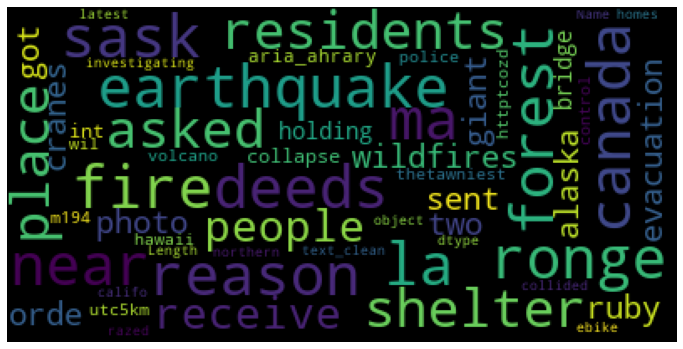

In [70]:
corpus = train["text_clean"]

wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(corpus))

fig = plt.figure(figsize=(12.0, 8.0), num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

### 単語ベクタライズ word embeddings

単語埋め込みを使うと、似たような単語が似たようにエンコードされる、効率的で密な表現が得られます。  
  
実行すると376.1MBのデータのダウンロードが始まる  

In [71]:
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [72]:
### 単語を選択
word = "dance"

In [74]:
labels, X, x, y = [], [], [], []

for t in nlp.most_similar(word, topn=20):
    X.append(nlp[t[0]])
    labels.append(t[0])

In [75]:
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')

new_values = pca.fit_transform(X)
for value in new_values:
    x.append(value[0])
    y.append(value[1])

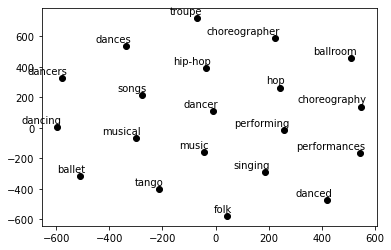

In [76]:
## グラフ
fig = plt.figure()
for i in range(len(x)):
    plt.scatter(x[i], y[i], c="black")
    plt.annotate(labels[i], xy=(x[i],y[i]), xytext=(5,2), 
               textcoords='offset points', ha='right', va='bottom')

Text(5, 2, 'dance')

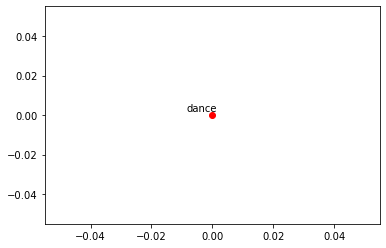

In [77]:
plt.scatter(x=0, y=0, c="red")

plt.annotate(word, xy=(0,0), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')

### LDAモデル

In [78]:
corpus = train["text_clean"]

# 前処理
lst_corpus = []

for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)

In [79]:
# 単語をＩＤに対応付ける
id2word = gensim.corpora.Dictionary(lst_corpus)

In [80]:
# 単語の頻出数の作成
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] 

In [81]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=3, 
                                            random_state=42, update_every=1, chunksize=100, 
                                            passes=10, alpha='auto', per_word_topics=True)

In [82]:
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
        
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

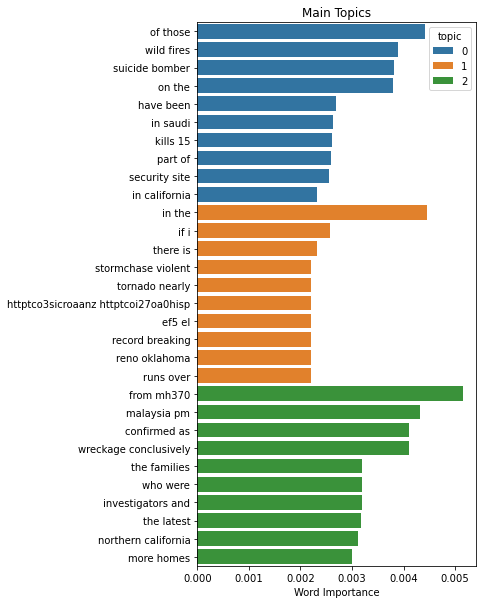

In [83]:
# グラフ
fig, ax = plt.subplots(figsize=(5, 10))
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()